following pipeline from [here](https://ucdavis-bioinformatics-training.github.io/2018-June-RNA-Seq-Workshop)

In [1]:
#BiocManager::install('topGO')
library(topGO)
library(KEGGREST)

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: graph

Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: GO.db

Loading required package: AnnotationDbi

Loading required package: stats4

Load

In [2]:
#source("https://bioconductor.org/biocLite.R")
BiocManager::install(c("org.Cr.virg.db", "Rgraphviz"))

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.2 (2023-10-31)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'Rgraphviz'”
Installing package(s) 'org.Cr.virg.db'

Warning message:
“package ‘org.Cr.virg.db’ is not available for Bioconductor version '3.18'

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Old packages: 'BH', 'biomaRt', 'Biostrings', 'brew', 'brio', 'bslib',
  'commonmark', 'cowplot', 'curl', 'data.table', 'DBI', 'desc', 'digest',
  'GenomicAlignments', 'ggfun', 'ggrepel', 'glue', 'GOSemSim', 'graphlayouts',
  'haven', 'htmlwidgets', 'httpuv', 'igraph', 'MASS', 'Matr

## Gene Ontology (GO) Enrichment

### 1. topGO example using KS Testing

In [3]:
infile <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/GO_enrichment_analysis/sig_p1_wc_genes_ALL.csv')
head(infile)

,X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,COX1,0.000000,NA,NA,NA,NA,NA
2,COX2,0.000000,NA,NA,NA,NA,NA
3,COX3,0.000000,NA,NA,NA,NA,NA
4,CYTB,0.000000,NA,NA,NA,NA,NA
5,LOC111099029,6.407219,-1.147078,0.6753391,-1.698521,0.08940949,0.3786324
6,LOC111099030,0.000000,NA,NA,NA,NA,NA


making sure my file is formatted like the example

In [4]:
# loading package to be able to use select() function
library(dplyr)

# selecting only columns I'll need
tmp <- select(infile, X, log2FoldChange, pvalue, padj)

# changing column names
colnames(tmp) <- c('gene', 'logFC', 'pval', 'padj')
head(tmp)

write.csv(tmp, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/GO_enrichment_analysis/geneList.txt')


Attaching package: ‘dplyr’


The following object is masked from ‘package:AnnotationDbi’:

    select


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following object is masked from ‘package:Biobase’:

    combine


The following object is masked from ‘package:graph’:

    union


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




,gene,logFC,pval,padj
,<chr>,<dbl>,<dbl>,<dbl>
1,COX1,NA,NA,NA
2,COX2,NA,NA,NA
3,COX3,NA,NA,NA
4,CYTB,NA,NA,NA
5,LOC111099029,-1.147078,0.08940949,0.3786324
6,LOC111099030,NA,NA,NA


In [5]:
class(tmp) # df

[1] "data.frame"

In [6]:
geneList <- tmp$pval
names(geneList) <- tmp$gene

head(geneList)
class(geneList) # numeric, used in allGenes for topGO object

COX1         COX2         COX3         CYTB LOC111099029 LOC111099030 
          NA           NA           NA           NA   0.08940949           NA

[1] "numeric"

In [7]:
geneID2GO <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/GO_enrichment_analysis/gene_GOid.csv')
#rownames(geneID2GO) = geneID2GO$gene_name
head(geneID2GO)

#write.csv(geneID2GO, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/GO_enrichment_analysis/gene_GOid.txt')

,gene_name,GO_id
,<chr>,<chr>
1,LOC111106242,GO:0005737; GO:0006693; GO:0032440; GO:0047522
2,LOC111108431,GO:0005737; GO:0006693; GO:0032440; GO:0047522
3,LOC111118924,GO:0004315; GO:0006633; GO:0008757; GO:0016491; GO:0031177
4,LOC111121098,GO:0005739; GO:0006869; GO:0008289; GO:0016747
5,LOC111121098,GO:0005739; GO:0006869; GO:0008289; GO:0016747
6,LOC111121707,GO:0004315; GO:0006633; GO:0008757; GO:0016491; GO:0031177


there's a problem because each row needs to be a unique gene... 

In [8]:
# Group by gene and clean up metadata with semicolon between GO terms
results <- geneID2GO %>% group_by(gene_name) %>% summarise(metadata = ifelse(all(is.na(GO_id)), 
                                                                             NA, 
                                                                             gsub("^\\s*;|;\\s*$", "", gsub(";+", ";", paste(na.omit(GO_id), collapse = ";")))))

# result_df now contains unique genes with concatenated metadata using semicolon
head(results)
# did further manipulation in excel (bc it was easier)
#write.csv(results, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/GO_enrichment_analysis/geneID2GO.txt')

gene_name,metadata
<chr>,<chr>
,GO:0046872;GO:0005576; GO:0045087; GO:0050829; GO:0050830;GO:0004867; GO:0005615;GO:0000786; GO:0003677; GO:0005634; GO:0030527; GO:0046982;GO:0004222; GO:0006508; GO:0008270; GO:0031012;GO:0005509; GO:0005788; GO:0006457; GO:0051082;GO:0005509; GO:0005783; GO:0006457; GO:0051082;GO:0000781; GO:0003677; GO:0003721; GO:0005634; GO:0046872;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0005524; GO:0005737; GO:0005856; GO:0016787;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0005743; GO:0009055; GO:0022904; GO:0046872; GO:0070469;GO:0005509;GO:0005737; GO:0008757; GO:0016226; GO:0051536;GO:0004176; GO:0004252; GO:0005524; GO:0006508; GO:0016887; GO:0030163;GO:0016620; GO:0051287;GO:0046872; GO:0051539;GO:0006508; GO:0008234;GO:0006508; GO:0008234;GO:0004713; GO:0005524; GO:0016310;GO:0003677; GO:0005634;GO:0006839; GO:0031966;GO:0016020;GO:0009916; GO:0016020; GO:0043229; GO:0046872;GO:0005506; GO:0016705; GO:0031418; GO:0051213;GO:0003746; GO:0005525;GO:0003746; GO:0005525;GO:0003729; GO:0046872;GO:0006629; GO:0008374;GO:0005507; GO:0006801;GO:0000981; GO:0003677; GO:0005634;GO:0016020;GO:0016020;GO:0016020;GO:0016020;GO:0003755;GO:0016020;GO:0015035;GO:0004497; GO:0005506; GO:0016705; GO:0020037
ATP6,GO:0005739; GO:0006754; GO:0016787; GO:0045263; GO:1902600
Biap,
COI,GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469
COX1,GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469;GO:0004129; GO:0005743; GO:0006119; GO:0020037; GO:0046872; GO:0070469
COX2,GO:0004129; GO:0005507; GO:0005743; GO:0070469


In [9]:
## NEED , BETWEEN GO TERMS NOT ;

# Read the content of the file into a character vector
file_path <- "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/GO_enrichment_analysis/geneID2GO.txt"
file_content <- readLines(file_path, warn = FALSE)

# Replace ';' with ','
file_content <- gsub(";", ",", file_content)

# Write the modified content back to the file
writeLines(file_content, file_path)

In [10]:
geneID2GO <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/GO_enrichment_analysis/geneID2GO.txt', sep='\t')
colnames(geneID2GO) = c('gene','GO_id')
head(geneID2GO)
dim(geneID2GO) # have 22,654 unique genes that have GO annotations

,gene,GO_id
,<chr>,<chr>
1,LOC111133408,GO:2001070
2,LOC111121603,"GO:2000781,GO:2000781"
3,LOC111132389,GO:2000145
4,LOC111115105,"GO:1990904,GO:1990904"
5,LOC111129853,"GO:1990904,GO:1990904"
6,LOC111101512,GO:1990904


[1] 22654     2

In [11]:
# have to create annotation file
geneID2GO <- readMappings(file = '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/GO_enrichment_analysis/geneID2GO.txt')
geneID2GO <- geneID2GO[-1] # removes header
head(geneID2GO)


$LOC111133408
[1] "GO:2001070"

$LOC111121603
[1] "GO:2000781" "GO:2000781"

$LOC111132389
[1] "GO:2000145"

$LOC111115105
[1] "GO:1990904" "GO:1990904"

$LOC111129853
[1] "GO:1990904" "GO:1990904"

$LOC111101512
[1] "GO:1990904"

In [12]:
geneNames <- names(geneID2GO)
head(geneNames)

[1] "LOC111133408" "LOC111121603" "LOC111132389" "LOC111115105" "LOC111129853"
[6] "LOC111101512"

In [13]:
# Assuming your dataframe is named 'your_df'
geneList <- replace(geneList, is.na(geneList), 0)

# Display the modified dataframe
head(geneList)
length(geneList)


COX1         COX2         COX3         CYTB LOC111099029 LOC111099030 
  0.00000000   0.00000000   0.00000000   0.00000000   0.08940949   0.00000000

[1] 39504

In [14]:
topDiffGenes <- function(allScore) {
    return(allScore < 0.01)
}

x <- topDiffGenes(geneList)
sum(x) ## the number of selected genes

[1] 22397

In [15]:
 GOdata <- new("topGOdata", 
               description = 'all genes in phase 1 warm vs. control',
               ontology = "MF", 
               allGenes = geneList,
               geneSel = topDiffGenes,
               annot = annFUN.gene2GO, 
               gene2GO = geneID2GO)


Building most specific GOs .....

	( 1276 GO terms found. )


Build GO DAG topology ..........

	( 1733 GO terms and 2266 relations. )


Annotating nodes ...............

	( 15613 genes annotated to the GO terms. )



In [16]:
GOdata


------------------------- topGOdata object -------------------------

 Description:
   -  all genes in phase 1 warm vs. control 

 Ontology:
   -  MF 

 39504 available genes (all genes from the array):
   - symbol:  COX1 COX2 COX3 CYTB LOC111099029  ...
   - score :  0 0 0 0 0.08940948526  ...
   - 22397  significant genes. 

 15613 feasible genes (genes that can be used in the analysis):
   - symbol:  COX1 COX2 COX3 CYTB LOC111099029  ...
   - score :  0 0 0 0 0.08940948526  ...
   - 7257  significant genes. 

 GO graph (nodes with at least  1  genes):
   - a graph with directed edges
   - number of nodes = 1733 
   - number of edges = 2266 

------------------------- topGOdata object -------------------------


In [17]:
resultKS <- runTest(GOdata, algorithm = "weight01", statistic = "ks")


			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 1733 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing


	 Level 13:	1 nodes to be scored	(0 eliminated genes)


	 Level 12:	3 nodes to be scored	(0 eliminated genes)


	 Level 11:	7 nodes to be scored	(2 eliminated genes)


	 Level 10:	24 nodes to be scored	(42 eliminated genes)


	 Level 9:	94 nodes to be scored	(79 eliminated genes)


	 Level 8:	161 nodes to be scored	(219 eliminated genes)


	 Level 7:	345 nodes to be scored	(2426 eliminated genes)


	 Level 6:	509 nodes to be scored	(3266 eliminated genes)


	 Level 5:	304 nodes to be scored	(6678 eliminated genes)


	 Level 4:	201 nodes to be scored	(9425 eliminated genes)


	 Level 3:	64 nodes to be scored	(12865 eliminated genes)


	 Level 2:	19 nodes to be scored	(13922 eliminated genes)


	 Level 1:	1 nodes to be scored	(15529 eliminated genes)



In [18]:
tab <- GenTable(GOdata, raw.p.value = resultKS, topNodes = length(resultKS@score), numChar = 120)

In [19]:
head(tab, 15)

,GO.ID,Term,Annotated,Significant,Expected,raw.p.value
,<chr>,<chr>,<int>,<int>,<dbl>,<chr>
1,GO:0005044,scavenger receptor activity,591,434,274.70,< 1e-30
2,GO:0004888,transmembrane signaling receptor activity,1162,794,540.10,< 1e-30
3,GO:0008270,zinc ion binding,2070,1070,962.15,< 1e-30
4,GO:0004930,G protein-coupled receptor activity,729,493,338.84,< 1e-30
5,GO:0005230,extracellular ligand-gated monoatomic ion channel activity,227,152,105.51,4.4e-16
6,GO:0003676,nucleic acid binding,2443,1157,1135.52,7.8e-16
7,GO:0004725,protein tyrosine phosphatase activity,276,149,128.29,2.6e-14
8,GO:0004867,serine-type endopeptidase inhibitor activity,116,90,53.92,2.3e-13
9,GO:0003677,DNA binding,1192,632,554.05,3.7e-13


In [20]:
par(cex = 0.3)
showSigOfNodes(GOdata, score(resultKS), firstSigNodes = 3, useInfo = "def")

Loading required package: Rgraphviz

Loading required package: grid


Attaching package: ‘grid’


The following object is masked from ‘package:topGO’:

    depth



Attaching package: ‘Rgraphviz’


The following objects are masked from ‘package:IRanges’:

    from, to


The following objects are masked from ‘package:S4Vectors’:

    from, to




ERROR: Error in if ((n <- as.integer(n[1L])) > 0) {: missing value where TRUE/FALSE needed


### 2. KEGG Pathway Enrichment Testing with KEGGREST

In [21]:
BiocManager::install('KEGGREST')
library(KEGGREST)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.2 (2023-10-31)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'KEGGREST'”
Old packages: 'BH', 'biomaRt', 'Biostrings', 'brew', 'brio', 'bslib',
  'commonmark', 'cowplot', 'curl', 'data.table', 'DBI', 'desc', 'digest',
  'GenomicAlignments', 'ggfun', 'ggrepel', 'glue', 'GOSemSim', 'graphlayouts',
  'haven', 'htmlwidgets', 'httpuv', 'igraph', 'MASS', 'Matrix', 'mgcv', 'nlme',
  'patchwork', 'pbdZMQ', 'pkgbuild', 'pkgload', 'ps', 'ragg', 'Rcpp',
  'RcppArmadillo', 'RCurl', 'readr', 'reprex', 'Rhtslib', 'rlang', 'scales',
  'shadowtext', 'shiny', 'SparseArray', 'testthat', 'tidygraph', 'tidyr',
  'timechange', 'uuid', 'viridis', 'vroom', 'withr', 'XML', 'xml2',
  

In [22]:
# Pull all pathways for CV
pathways.list <- keggList("pathway", "cvn")
head(pathways.list)

cvn01100 
             "Metabolic pathways - Crassostrea virginica (eastern oyster)" 
                                                                  cvn01200 
              "Carbon metabolism - Crassostrea virginica (eastern oyster)" 
                                                                  cvn01210 
"2-Oxocarboxylic acid metabolism - Crassostrea virginica (eastern oyster)" 
                                                                  cvn01212 
          "Fatty acid metabolism - Crassostrea virginica (eastern oyster)" 
                                                                  cvn01230 
    "Biosynthesis of amino acids - Crassostrea virginica (eastern oyster)" 
                                                                  cvn01232 
          "Nucleotide metabolism - Crassostrea virginica (eastern oyster)"

In [30]:
# Pull all genes for each pathway
pathway.codes <- sub("path:", "", names(pathways.list)) 
genes.by.pathway <- sapply(pathway.codes,
    function(pwid){
        pw <- keggGet(pwid)
        if (is.null(pw[[1]]$GENE)) return(NA)
        pw2 <- pw[[1]]$GENE[c(TRUE, FALSE)] # may need to modify this to c(FALSE, TRUE) for other organisms
        pw2 <- unlist(lapply(strsplit(pw2, split = ";", fixed = T), function(x)x[1]))
        return(pw2)
    }
)
head(genes.by.pathway)

$cvn01100
[1] NA

$cvn01200
[1] NA

$cvn01210
[1] NA

$cvn01212
[1] NA

$cvn01230
[1] NA

$cvn01232
[1] NA

In [31]:
head(genes.by.pathway, 15)

$cvn01100
[1] NA

$cvn01200
[1] NA

$cvn01210
[1] NA

$cvn01212
[1] NA

$cvn01230
[1] NA

$cvn01232
[1] NA

$cvn01250
[1] NA

$cvn01240
[1] NA

$cvn00010
 [1] "111135700" "111099882" "111100475" "111136543" "111137391" "111124867"
 [7] "111130977" "111135106" "111136940" "111132917" "111099143" "111122808"
[13] "111111035" "111100351" "111137133" "111116965" "111138044" "111099657"
[19] "111107273" "111127323" "111108359" "111109254" "111118136" "111119958"
[25] "111130419" "111103451" "111103498" "111130726" "111131063" "111112920"
[31] "111115614" "111134997" "111130514" "111119284" "111130103" "111131530"
[37] "111131531" "111135159" "111128136" "111129194" "111118006" "111125502"
[43] "111101224" "111102836" "111130458" "111127779" "111129670" "111128311"
[49] "111119955" "111119956" "111134713" "111135400"

$cvn00020
 [1] "111111213" "111103886" "111121719" "111121721" "111117101" "111117164"
 [7] "111117165" "111101916" "111103250" "111131515" "111109973" "111123350"
[13] "111110280" "111125610" "111128143" "111118600" "111131212" "111108359"
[19] "111109254" "111101152" "111105866" "111105925" "111101642" "111100625"
[25] "111104247" "111137688" "111127095" "111132318" "111132960" "111130667"
[31] "111129934" "111136621" "111128687" "111128990" "111134713" "111135400"
[37] "111099657" "111107273" "111127323"

$cvn00030
 [1] "111136543" "111137391" "111110098" "111123214" "111136873" "111137005"
 [7] "111120752" "111109650" "111105262" "111105573" "111124565" "111133422"
[13] "111131435" "111131512" "111130478" "111130276" "111118006" "111125502"
[19] "111123753" "111120853" "111121418" "111121420" "111128802" "111129363"
[25] "111108492" "111135106" "111136940" "111130977" "111124867"

$cvn00040
 [1] "111135080" "111124535" "111124599" "111130500" "111105314" "111120752"
 [7] "111135776" "111118569" "111109436" "111109438" "111109441" "111109442"
[13] "111120655" "111131336" "111131432" "111133902" "111128111" "111104054"
[19] "111134996" "111101743" "111107703"

$cvn00051
 [1] "111132784" "111132797" "111133304" "111108764" "111109888" "111124900"
 [7] "111138520" "111099454" "111099690" "111127223" "111135841" "111122412"
[13] "111119078" "111119251" "111135700" "111099882" "111100475" "111124867"
[19] "111130977" "111107727" "111103044" "111103135" "111136353" "111137741"
[25] "111131336" "111131432" "111133902" "111128111" "111104054" "111109436"
[31] "111109438" "111109441" "111109442" "111118569" "111135106" "111136940"
[37] "111132917" "111131560" "111131656"

$cvn00052
 [1] "111131530" "111131531" "111135159" "111128136" "111129194" "111118471"
 [7] "111128700" "111128748" "111122398" "111130500" "111118006" "111125502"
[13] "111135700" "111099882" "111100475" "111101224" "111102836" "111113388"
[19] "111136393" "111136395" "111101197" "111101820" "111118783" "111104545"
[25] "111119763" "111119792" "111119793" "111131415" "111109436" "111109438"
[31] "111109441" "111109442" "111124867" "111099715" "111099716" "111119014"
[37] "111119178" "111125646" "111120703" "111099718"

$cvn00053
 [1] "111124535" "111124599" "111135080" "111127562" "111120853" "111121418"
 [7] "111121420" "111130419" "111103451" "111103498" "111130726" "111131063"
[13] "111112920" "111115614"

In [76]:
# reading in df
gene_df <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/GO_enrichment_analysis/geneList.txt')
head(gene_df)

# creating new df of just gene and logFC
geneList <- data.frame(gene_df$gene, gene_df$pval)
colnames(geneList) = c('gene', 'pval')
head(geneList)

,X,gene,logFC,pval,padj
,<int>,<chr>,<dbl>,<dbl>,<dbl>
1,1,COX1,NA,NA,NA
2,2,COX2,NA,NA,NA
3,3,COX3,NA,NA,NA
4,4,CYTB,NA,NA,NA
5,5,LOC111099029,-1.147078,0.08940949,0.3786324
6,6,LOC111099030,NA,NA,NA


,gene,pval
,<chr>,<dbl>
1,COX1,NA
2,COX2,NA
3,COX3,NA
4,CYTB,NA
5,LOC111099029,0.08940949
6,LOC111099030,NA


In [77]:
# Assuming your dataframe is named 'your_df'
geneList$gene <- sub("^LOC", "", geneList$gene)

# Display the modified dataframe
#rownames(gL_df) = gL_df$gene
#gL_df <- gL_df[,-1]
#gL_df
head(geneList)

,gene,pval
,<chr>,<dbl>
1,COX1,NA
2,COX2,NA
3,COX3,NA
4,CYTB,NA
5,111099029,0.08940949
6,111099030,NA


In [78]:
geneL <- geneList$pval
names(geneL) <- geneList$gene

head(geneL)
class(geneL) # numeric, used in allGenes for topGO object

COX1       COX2       COX3       CYTB  111099029  111099030 
        NA         NA         NA         NA 0.08940949         NA

[1] "numeric"

In [79]:
# Wilcoxon test for each pathway
pVals.by.pathway <- t(sapply(names(genes.by.pathway),
    function(pathway) {
        pathway.genes <- genes.by.pathway[[pathway]]
        list.genes.in.pathway <- intersect(names(geneL), pathway.genes)
        list.genes.not.in.pathway <- setdiff(names(geneL), list.genes.in.pathway)
        scores.in.pathway <- geneL[list.genes.in.pathway]
        scores.not.in.pathway <- geneL[list.genes.not.in.pathway]
        if (length(scores.in.pathway) > 0){
            p.value <- wilcox.test(scores.in.pathway, scores.not.in.pathway, alternative = "less")$p.value
        } else{
            p.value <- NA
        }
        return(c(p.value = p.value, Annotated = length(list.genes.in.pathway)))
    }
))

# Assemble output table
outdat <- data.frame(pathway.code = rownames(pVals.by.pathway))
outdat$pathway.name <- pathways.list[outdat$pathway.code]
outdat$p.value <- pVals.by.pathway[,"p.value"]
outdat$Annotated <- pVals.by.pathway[,"Annotated"]
outdat <- outdat[order(outdat$p.value),]
head(outdat)

,pathway.code,pathway.name,p.value,Annotated
,<chr>,<chr>,<dbl>,<dbl>
128,cvn04144,Endocytosis - Crassostrea virginica (eastern oyster),1.942379e-06,219
107,cvn03410,Base excision repair - Crassostrea virginica (eastern oyster),1.004289e-05,57
123,cvn04068,FoxO signaling pathway - Crassostrea virginica (eastern oyster),2.135655e-05,86
22,cvn00562,Inositol phosphate metabolism - Crassostrea virginica (eastern oyster),2.288142e-05,53
93,cvn03040,Spliceosome - Crassostrea virginica (eastern oyster),3.496073e-05,141
106,cvn03030,DNA replication - Crassostrea virginica (eastern oyster),9.874524e-05,41


In [80]:
outdat

,pathway.code,pathway.name,p.value,Annotated
,<chr>,<chr>,<dbl>,<dbl>
128,cvn04144,Endocytosis - Crassostrea virginica (eastern oyster),1.942379e-06,219
107,cvn03410,Base excision repair - Crassostrea virginica (eastern oyster),1.004289e-05,57
123,cvn04068,FoxO signaling pathway - Crassostrea virginica (eastern oyster),2.135655e-05,86
22,cvn00562,Inositol phosphate metabolism - Crassostrea virginica (eastern oyster),2.288142e-05,53
93,cvn03040,Spliceosome - Crassostrea virginica (eastern oyster),3.496073e-05,141
106,cvn03030,DNA replication - Crassostrea virginica (eastern oyster),9.874524e-05,41
132,cvn04140,Autophagy - animal - Crassostrea virginica (eastern oyster),3.163898e-04,141
42,cvn00270,Cysteine and methionine metabolism - Crassostrea virginica (eastern oyster),9.551869e-04,65
105,cvn03018,RNA degradation - Crassostrea virginica (eastern oyster),1.104870e-03,94


### clusterProfiler 

creating kegg object for downstream analysis/visualization (following info from [here](https://learn.gencore.bio.nyu.edu/rna-seq-analysis/gene-set-enrichment-analysis/))

In [89]:
head(gene_df)

,X,gene,logFC,pval,padj
,<int>,<chr>,<dbl>,<dbl>,<dbl>
1,1,COX1,NA,NA,NA
2,2,COX2,NA,NA,NA
3,3,COX3,NA,NA,NA
4,4,CYTB,NA,NA,NA
5,5,LOC111099029,-1.147078,0.08940949,0.3786324
6,6,LOC111099030,NA,NA,NA


In [100]:
# getting list of genes
write.csv(gene_list, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/GO_enrichment_analysis/geneIDs.csv')

In [115]:
df <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/significant_genes/sig_p1_wc_genes.csv')

df <- select(df, Row.names, log2FoldChange, pvalue, padj)
colnames(df) = c('gene', 'logFC', 'pval', 'padj')
head(df)

,gene,logFC,pval,padj
,<chr>,<dbl>,<dbl>,<dbl>
1,LOC111099115,1.7885864,4.161092e-06,0.0002004183
2,LOC111099216,1.4828614,7.544561e-04,0.0125496496
3,LOC111099417,2.7487429,6.452048e-05,0.0019567084
4,LOC111099424,3.4384445,3.211770e-05,0.0010745946
5,LOC111099722,0.8993515,1.093514e-04,0.0028699825
6,LOC111099918,0.6567512,3.539745e-03,0.0407210025


went from ensembl IDs to entrez IDs using the DAVID id conversion web tool

In [118]:
david_df <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/KEGG_pathway/p1_wc_DAVID_conversion.txt', sep='\t')
# only selecting columns that I need
david_df <- select(david_df, From, To)
# renaming columns for merge
colnames(david_df) = c('gene', 'entrez_ID')
head(david_df)

,gene,entrez_ID
,<chr>,<int>
1,LOC111134684,111134684
2,LOC111110475,111110475
3,LOC111132265,111132265
4,LOC111135536,111135536
5,LOC111099115,111099115
6,LOC111136502,111136502


now need to match up dataframes - so entrez ID is with log2FoldChange and pval for GSEA

```merged_df <- merge(df1, df2, by = "ID", all = TRUE)```

In [120]:
merge_df <- merge(david_df, df, by = "gene", all = TRUE)
head(merge_df)

,gene,entrez_ID,logFC,pval,padj
,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,LOC111099115,111099115,1.7885864,4.161092e-06,0.0002004183
2,LOC111099216,111099216,1.4828614,7.544561e-04,0.0125496496
3,LOC111099417,111099417,2.7487429,6.452048e-05,0.0019567084
4,LOC111099424,111099424,3.4384445,3.211770e-05,0.0010745946
5,LOC111099722,111099722,0.8993515,1.093514e-04,0.0028699825
6,LOC111099918,111099918,0.6567512,3.539745e-03,0.0407210025


In [123]:
log_df <- data.frame(merge_df$entrez_ID, merge_df$logFC)
colnames(log_df) = c('gene', 'logFC')
head(log_df)

,gene,logFC
,<int>,<dbl>
1,111099115,1.7885864
2,111099216,1.4828614
3,111099417,2.7487429
4,111099424,3.4384445
5,111099722,0.8993515
6,111099918,0.6567512


In [168]:
length(unique(names(kegg_gene_list))) # 401 genes
length(kegg_gene_list) # 405 genes

# so need to remove duplicates

length(unique(log_df$gene))
length(log_df$gene)

dedup_df <- log_df[!duplicated(log_df$gene),]

[1] 401

[1] 405

[1] 401

[1] 405

In [189]:
# Create a vector of the gene unuiverse
kegg_gene_list <- dedup_df$logFC

# Name vector with ENTREZ ids
names(kegg_gene_list) <- dedup_df$gene

# omit any NA values 
kegg_gene_list<-na.omit(kegg_gene_list)

# sort the list in decreasing order (required for clusterProfiler)
kegg_gene_list = sort(kegg_gene_list, decreasing = TRUE)

head(kegg_gene_list)

111114820 111114521 111119752 111107999 111105528 111125118 
 7.304551  6.538482  6.248138  6.053723  6.017344  5.965434

In [192]:
### looking at pval metric

pval_df <- data.frame(merge_df$entrez_ID, merge_df$pval)
colnames(pval_df) = c('gene', 'pval')
head(pval_df)

length(unique(names(kegg_gene_list))) # 401 genes
length(kegg_gene_list) # 405 genes

# so need to remove duplicates

length(unique(pval_df$gene))
length(pval_df$gene)

dedup_pval_df <- pval_df[!duplicated(pval_df$gene),]

# Create a vector of the gene unuiverse
kegg_gene_list <- dedup_pval_df$pval

# Name vector with ENTREZ ids
names(kegg_gene_list) <- dedup_pval_df$gene

# omit any NA values 
kegg_gene_list<-na.omit(kegg_gene_list)

# sort the list in decreasing order (required for clusterProfiler)
kegg_gene_list = sort(kegg_gene_list, decreasing = TRUE)

head(kegg_gene_list)

,gene,pval
,<int>,<dbl>
1,111099115,4.161092e-06
2,111099216,7.544561e-04
3,111099417,6.452048e-05
4,111099424,3.211770e-05
5,111099722,1.093514e-04
6,111099918,3.539745e-03


[1] 401

[1] 401

[1] 401

[1] 405

111134449   111128484   111128891   111137876   111106619   111130297 
0.004590962 0.004574794 0.004451712 0.004396402 0.004391853 0.004379426

In [195]:
kegg_organism = "cvn"
kk2 <- gseKEGG(geneList     = kegg_gene_list,
               organism     = kegg_organism,
               #nPerm        = 10000,
               minGSSize    = 1,
               maxGSSize    = 800,
               pvalueCutoff = 0.05,
               pAdjustMethod = "none",
               scoreType = "pos",
               keyType       = "ncbi-geneid")

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...



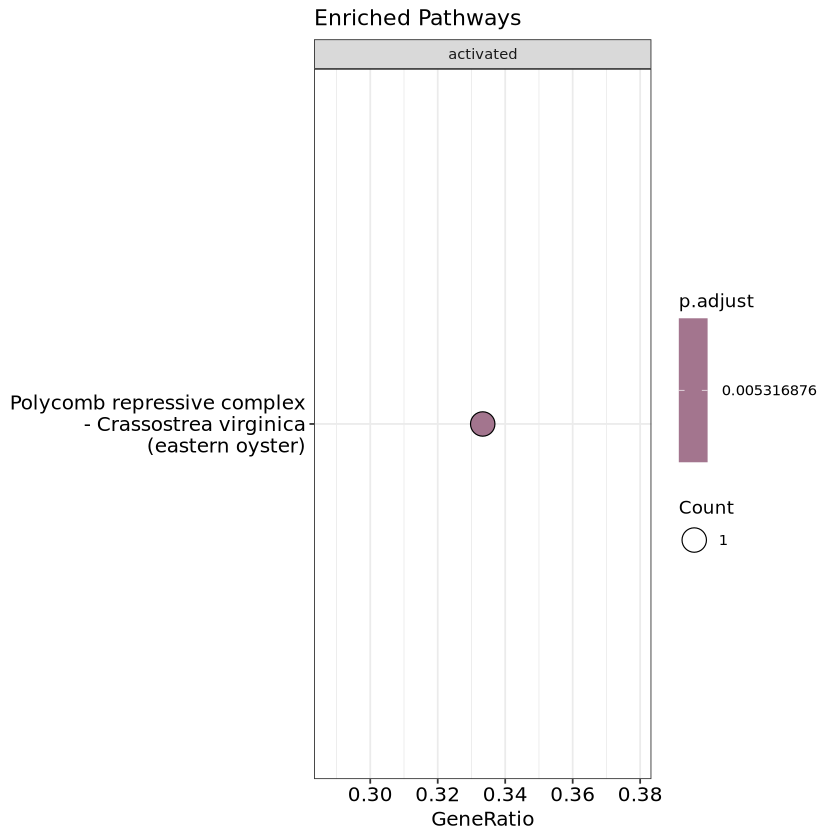

In [196]:
dotplot(kk2, showCategory = 10, title = "Enriched Pathways" , split=".sign") + facet_grid(.~.sign)

In [182]:
 emapplot(kk2)

ERROR: Error in has_pairsim(x): Term similarity matrix not available. Please use pairwise_termsim function to deal with the results of enrichment analysis.


In [183]:
# categorySize can be either 'pvalue' or 'geneNum'
cnetplot(kk2, categorySize="pvalue", foldChange=gene_list)

Warning message in cnetplot.enrichResult(x, ...):
“Use 'color.params = list(foldChange = your_value)' instead of 'foldChange'.
 The foldChange parameter will be removed in the next version.”


ERROR: Error in i_set_vertex_attr(x, attr(value, "name"), index = value, value = attr(value, : Length of new attribute value must be 1 or 2, the number of target vertices, not 3


In [184]:
#BiocManager::install('ggridges')
library(ggridges)

Picking joint bandwidth of NaN



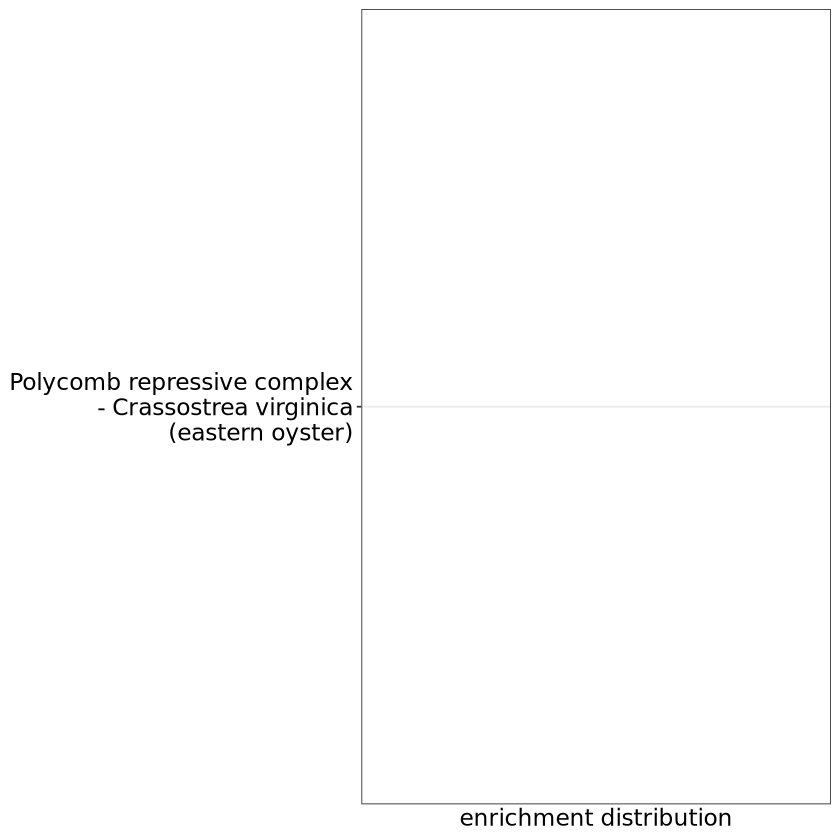

In [185]:
ridgeplot(kk2) + labs(x = "enrichment distribution")